## import & utils


In [2]:
from collections import namedtuple
from functools import partial
import numpy as np
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
from types import SimpleNamespace as Bunch
from IPython.display import clear_output, Image
import plotly.graph_objects as go
from ipywidgets import interact
from tqdm.auto import tqdm, trange

pl.style.use("dark_background")


def np2pil(a):
    a = np.asarray(a)
    if a.dtype.kind == "f":
        a = np.uint8(a.clip(0, 1) * 255)
    return PIL.Image.fromarray(a)


def imshow(a):
    display(np2pil(a))


def zoom(a, k=2):
    return np.repeat(np.repeat(a, k, 1), k, 0)


def tile2d(a, w=None):
    a = np.asarray(a)
    if w is None:
        w = int(np.ceil(np.sqrt(len(a))))
    th, tw = a.shape[1:3]
    pad = (w - len(a)) % w
    a = np.pad(a, [(0, pad)] + [(0, 0)] * (a.ndim - 1), "constant")
    h = len(a) // w
    a = a.reshape([h, w] + list(a.shape[1:]))
    a = np.rollaxis(a, 2, 1).reshape([th * h, tw * w] + list(a.shape[4:]))
    return a

In [3]:
import jax
import jax.numpy as jp
import optax

In [4]:
%load_ext autoreload
%autoreload 2

## Params

In [13]:
input_n, output_n = 8, 8
case_n = 1 << input_n
arity, layer_width, layer_n = 4, 64, 5
layer_sizes = (
    [(input_n, 1)]
    + [(layer_width, arity)] * (layer_n - 1)
    + [(layer_width // 2, arity // 2), (output_n, 1)]
)
loss_type = "bce"

## Training


In [27]:
from model import gen_circuit, run_circuit
from training import TrainState, train_step, unpack

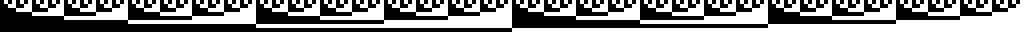

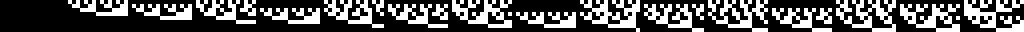

In [21]:
key = jax.random.PRNGKey(42)
wires, logits0 = gen_circuit(key, layer_sizes)

opt = optax.adamw(1.0, 0.8, 0.8, weight_decay=0.1)
state = TrainState(params=logits0, opt_state=opt.init(logits0))


x = jp.arange(case_n)
y0 = (x & 0xF) * (x >> 4)
x, y0 = unpack(x), unpack(y0)


imshow(zoom(x.T, 4))
imshow(zoom(y0.T, 4))

In [24]:
loss_log = []

In [25]:
pbar = trange(1000)
for i in pbar:
    loss, state = train_step(state, opt, wires, x, y0)
    loss_log.append(loss)
    pbar.set_postfix_str(f"loss: {loss.item():.3E}")

  0%|          | 0/1000 [00:00<?, ?it/s]

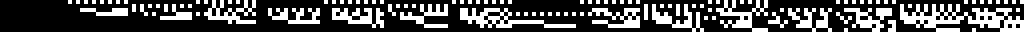

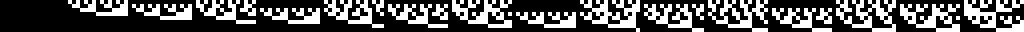

In [28]:
act = run_circuit(state.params, wires, x, hard=True)

y = act[-1]
imshow(zoom(y, 4).T)
imshow(zoom(y0, 4).T)

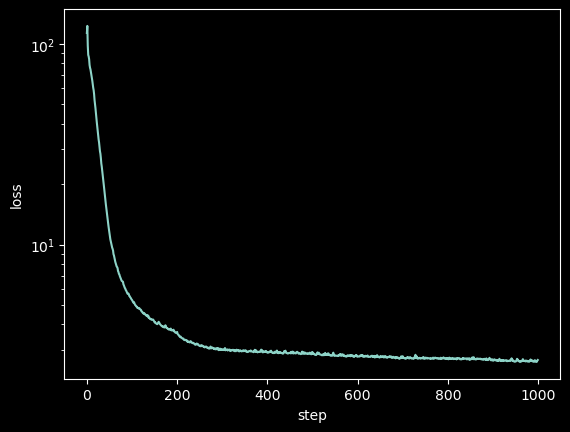

In [29]:
plt.plot(loss_log)
plt.yscale("log")
plt.xlabel("step")
plt.ylabel("loss")
plt.show()